In [2]:
import numpy as np
from matplotlib import pyplot as plt
import os
from sklearn.neighbors import KNeighborsRegressor
import sklearn.neighbors

%matplotlib inline

In [3]:
bits = 4096
n_neighbours = 128
os.environ['LSH_SAMPLE_BITS'] = str(bits)

In [18]:
! python ../etc/stub_data_generator.py 100000 ${LSH_SAMPLE_BITS} --out ./ls_stub_train_data
! python ../etc/stub_data_generator.py 10000 ${LSH_SAMPLE_BITS} --out ./ls_stub_test_data

In [19]:
def parse_input(in_file):
    rows = file(in_file).readlines()
    
    N = len(rows)
    X = np.zeros((N, bits))
    
    for row in rows:
        row_fields = row.split()
        row_id = int(row_fields[0])
        for bit in row_fields[1:]:
            X[row_id, int(bit)] = 1
            
    return X

In [20]:
gt_knn = KNeighborsRegressor(metric='hamming')
X_train = parse_input('./ls_stub_train_data')
X_test = parse_input('./ls_stub_test_data')

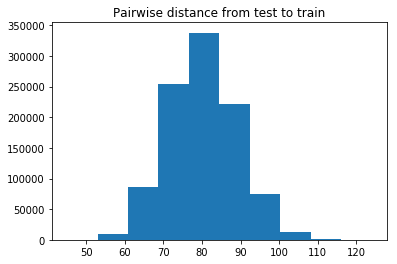

In [22]:
dist = sklearn.neighbors.DistanceMetric.get_metric('hamming')
_ = plt.hist((dist.pairwise(X_test[:1000], X_train[:1000]) * bits).ravel())
plt.title("Pairwise distance from test to train")

## LSH k-rnn result

In [161]:
! time ../build/krnn -H 1024 -s128 -k  -r 50 -a 0.5 -t0.1 -d4096 ../etc/ls_stub_train_data ../etc/ls_stub_test_data > ../etc/ls_stub_result

In [162]:
def parse_result(fname):
    rows = file(fname).readlines()
    neighbours = []
    for row in rows:
        neighbours.append([int(x) for x in row.split()[1:]])
    return neighbours

In [163]:
lsh_result = parse_result('../etc/stub_result')

lsh_distances = []
for test_id, neighbours in enumerate(lsh_result):
    lsh_distances+=list(dist.pairwise(X_test[test_id: test_id+1], X_train[neighbours])[0] * bits)
    

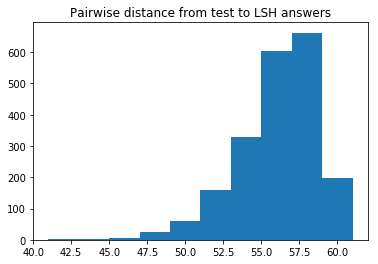

In [164]:
_ = plt.hist(lsh_distances)
plt.title("Pairwise distance from test to LSH answers")

In [165]:
lsh_counts = [len(x) for x in lsh_result]
np.all(np.array(lsh_counts) == 32)

True

## Sklearn KNN

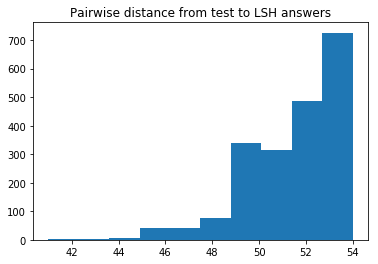

In [166]:
gt_knn.fit(X_train, np.ones(len(X_train)))
gt_d, gt_neighbours = gt_knn.kneighbors(X_test, 32)
_ = plt.hist(gt_d.ravel()* bits)
plt.title("Pairwise distance from test to LSH answers")

In [167]:
def ioc(lsh, knn):
    r = []
    for test_id in range(len(lsh)):
        i = len(set(lsh[test_id]) & set(knn[test_id]))
        u = len(set(lsh[test_id]) | set(knn[test_id]))
        r.append(i / float(u))
        
        
    return np.array(r)

ioc_values = ioc(lsh_result, gt_neighbours)

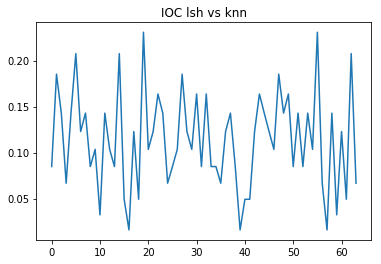

In [168]:
plt.title('IOC lsh vs knn')
plt.plot(ioc_values)

(array([  1.,   1.,   0.,   0.,   1.,   5.,   0.,   5.,   8.,  11.]),
 array([ 46. ,  46.7,  47.4,  48.1,  48.8,  49.5,  50.2,  50.9,  51.6,
         52.3,  53. ]),
 <a list of 10 Patch objects>)

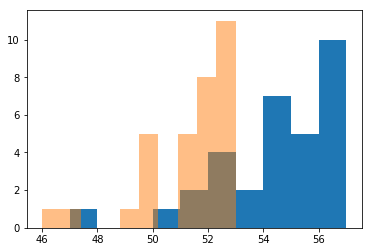

In [169]:
lsh_distances = np.array(lsh_distances).reshape(64, -1)

plt.hist(lsh_distances[1])
plt.hist(gt_d[1]*128, alpha=0.5)